In [1]:
import pickle
from pathlib import Path
import json
import io
from typing import Any

import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.special import expit, logit
from sklearn.preprocessing import quantile_transform
from sklearn.cluster import AgglomerativeClustering
from tqdm.auto import tqdm
from datasets import load_dataset, Audio

from src.spectrogram_transformer import AudioSpectrogramTransformer

In [2]:
ast = AudioSpectrogramTransformer()

In [3]:
labels = json.loads(Path('audioset/labels.json').read_text())
correlations = np.load(io.BytesIO(Path('audioset/correlations.npy').read_bytes()), allow_pickle=False)
audioset_logits = pickle.loads(Path('tmp/audioset_logits.pkl').read_bytes())
audioset_span_average_probas = pickle.loads(Path('tmp/audioset_span_average_probas.pkl').read_bytes())

In [4]:
cache_file = Path('tmp/audioset_predictions.pkl')

if not cache_file.is_file():
    audioset = (
        # it downloads also balanced_train split, don't know how to skip it
        load_dataset('agkphysics/AudioSet', split='test', trust_remote_code=True)
        .cast_column('audio', Audio(decode=False))  # some audio files seem to be malformed
    )

    def predict_on_audioset_with_ast(sample: dict[str, Any]):
        try:
            waveform, _ = librosa.load(io.BytesIO(sample['audio']['bytes']), sr=16_000)
            # some waveforms are shorter than 10 seconds,
            # so it's simpler (but longer) to predict without batching
            logits = ast.predict_on_batch(waveform[None], sampling_rate=16_000)[0]
        except ValueError:
            # some audio files seem to be malformed
            logits = None
        return {'logits': logits}

    audioset_predictions = list(
        audioset.map(predict_on_audioset_with_ast, num_proc=1).remove_columns('audio')
    )
    cache_file.write_bytes(pickle.dumps(audioset_predictions))

else:
    print('Using cached predictions')
    audioset_predictions = pickle.loads(cache_file.read_bytes())

Using cached predictions


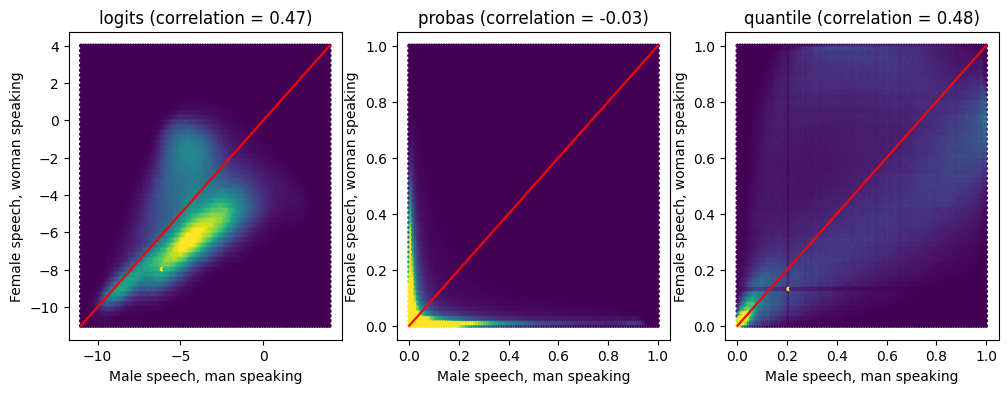

In [5]:
cls1 = 'Male speech, man speaking'
cls2 = 'Female speech, woman speaking'

cls1_logits = audioset_logits.data[:, labels.index(cls1)]
cls2_logits = audioset_logits.data[:, labels.index(cls2)]

cls1_probas = expit(cls1_logits)
cls2_probas = expit(cls2_logits)

cls1_quantile = quantile_transform(cls1_logits[:, None])[:, 0]
cls2_quantile = quantile_transform(cls2_logits[:, None])[:, 0]

fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

for ax, source_name, (x, y) in zip(
    axs,
    ('logits', 'probas', 'quantile'),
    ((cls1_logits, cls2_logits), (cls1_probas, cls2_probas), (cls1_quantile, cls2_quantile))
):
    extent = [[-11, 4], [-11, 4]] if x.min() < 0 or y.min() < 0 else [[0, 1], [0, 1]]
    correlation = np.corrcoef([x, y])[0, 1]
    ax.hexbin(x, y, vmax=5000, extent=extent[0] + extent[1])
    ax.plot(*extent, color='r')
    ax.set_xlabel(cls1)
    ax.set_ylabel(cls2)
    ax.set_title(f'{source_name} (correlation = {correlation:.2f})')

plt.show()

In [6]:
from src.audioset_utils import get_class_sets
acoustic_label_names = np.array(list(set([i for i in get_class_sets('audioset/audioset_ontology.json')['acoustic'] if i in labels])))
acoustic_label_idxs = np.array([labels.index(name) for name in acoustic_label_names])

order = np.argsort(np.median(audioset_logits.data[:, acoustic_label_idxs], axis=0))[::-1]
acoustic_label_names = acoustic_label_names[order]
acoustic_label_idxs = acoustic_label_idxs[order]

In [ ]:
# fig, axs = plt.subplots(figsize=(15, 40), nrows=150)

# for ax, label_idx in zip(tqdm(axs), acoustic_label_idxs):
#     values = audioset_span_average_probas.data[:, label_idx]

#     ax.hist(values, bins=500, range=(0, 0.02))
#     ax.text(-0.005, 0, labels[label_idx])
#     ax.axis('off')

#     log_proba_threshold = log_proba_thresholds[labels[label_idx]]
#     if log_proba_threshold is not None:
#         # print(labels[label_idx], expit(log_proba_threshold))
#         ax.axvline(expit(log_proba_threshold), color='r')
    
#     ax.set_xlim(-0.01, 0.05)

# plt.show()

In [ ]:
class_data = {}

for label_idx, label_name in tqdm(zip(acoustic_label_idxs, acoustic_label_names)):
    truth = np.array([
        label_name in s['human_labels']
        for s in audioset_predictions
    ])
    pred = np.array([
        s['logits'][label_idx] if s['logits'] is not None else np.nan
        for s in audioset_predictions
    ])

    # skipping malformed audio files with no preds
    isnan = np.isnan(pred)
    truth = truth[~isnan]
    pred = pred[~isnan]

    # sorting by predicted score
    order = np.argsort(pred)
    ordered_truth = truth[order]
    ordered_pred = pred[order]
    del truth, pred

    precisions = np.cumsum(ordered_truth[::-1]) / np.arange(1, len(ordered_truth) + 1)[::-1]

    yodas_pred = audioset_logits.data[:, label_idx]
    quantiles = expit(np.linspace(-30, 30, num=500))
    yodas_quantiles_values = np.quantile(yodas_pred, quantiles)

    ordered_pred_yodas_quantiles = np.interp(ordered_pred, yodas_quantiles_values, quantiles)

    class_data[label_idx] = {
        'ordered_truth': ordered_truth,
        'ordered_pred': ordered_pred,
        'precisions': precisions,
        'ordered_pred_yodas_quantiles': ordered_pred_yodas_quantiles,
    }

0it [00:00, ?it/s]

In [ ]:
# logit_thresholds = np.linspace(-5, 2, num=10)
# logit_quantile_thresholds = np.linspace(2, 10, num=10)
# c_range = np.linspace(0, 10, num=100)

# rules_quality = np.full((len(logit_thresholds), len(logit_quantile_thresholds)), np.nan)

# for logit_threshold_idx, logit_threshold in enumerate(logit_thresholds):
#     for logit_quantile_threshold_idx, logit_quantile_threshold in enumerate(logit_quantile_thresholds):
#         for c_idx, c in enumerate(c_range):
#             for label_idx in acoustic_label_idxs:
#                 logits = np.array(class_data[label_idx]['ordered_pred'])
#                 logit_quantiles = expit(class_data[label_idx]['ordered_pred_yodas_quantiles'])
                


#             break
#         break
#     break

0it [00:00, ?it/s]

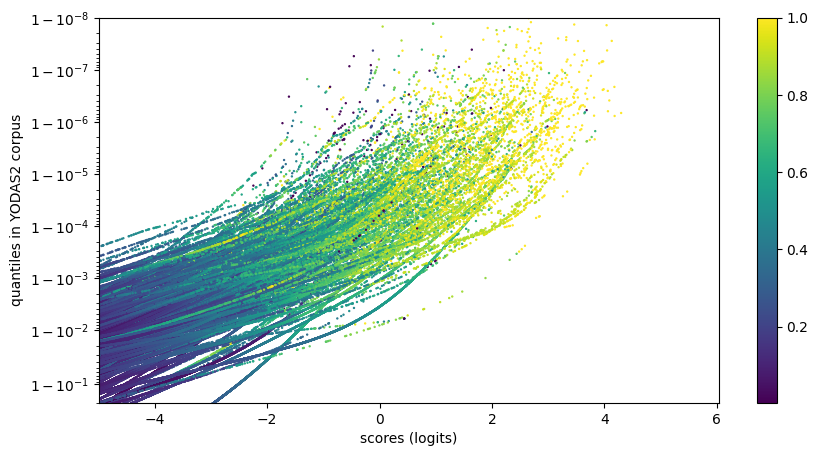

In [53]:
plt.figure(figsize=(10, 5))

for plot_idx, (label_idx, label_name) in tqdm(enumerate(zip(acoustic_label_idxs, acoustic_label_names))):

    # if plot_idx > 10:
    #     break

    data = class_data[label_idx]

    plt.scatter(data['ordered_pred'], data['ordered_pred_yodas_quantiles'], c=data['precisions'], s=0.5)

    # precision_is_good = np.where(np.array(data['precisions']) > 0.4)[0]
    # if len(precision_is_good):
    #     idx_of_interest = min(precision_is_good)
    #     plt.scatter(
    #         [data['ordered_pred'][idx_of_interest]],
    #         [data['ordered_pred_yodas_quantiles'][idx_of_interest]],
    #         s=5,
    #         color='r',
    #         zorder=2
    #     )

plt.colorbar()
plt.yscale('logit')
plt.xlabel('scores (logits)')
plt.ylabel('quantiles in YODAS2 corpus')
plt.ylim(0.8, 1 - 1e-8)
plt.xlim(-5, None)
plt.show()

In [ ]:
# plt.figure(figsize=(15, 3))
# plt.title(label_name)
# ax = plt.gca()
# ax2 = ax.twinx()

# ax.plot(ordered_pred, precisions)

# ax2.hist(
#     yodas_pred,
#     bins=np.linspace(ordered_pred[0], ordered_pred[-1], num=100),
#     color='C1',
#     alpha=0.1,
# )

# plt.scatter(np.arange(len(ordered_pred)), ordered_truth, marker='|')

# window_size = 10
# averaged_truth = np.convolve(ordered_truth, np.ones(window_size) / window_size, mode='valid')
# plt.fill_between(x[(window_size - 1) // 2 : -(window_size // 2)], 0, averaged_truth, zorder=-1)
# plt.plot(np.arange(len(ordered_pred))[:-min_samples_to_calc_precision], precisions, color='C1')

# if log_proba_threshold is not None:
#     plt.axvline(log_proba_threshold_idx, color='r')

# yodas_log_probas = audioset_logits.data[:, label_idx]
# yodas_hist, bin_edges = np.histogram(yodas_log_probas, bins=ordered_pred)

# tick_interval = 200
# ticks = ordered_pred[::tick_interval]
# plt.gca().set_xticks(np.arange(len(ticks)) * tick_interval)
# plt.gca().set_xticklabels([f'{expit(x) * 100:g}' for x in ticks], rotation=90)
# plt.xlabel('predicted proba, %')

# plt.ylim(-0.2, 1.2)
# plt.gca().set_yticks([0, 1])
# plt.gca().set_yticklabels(['False', 'True'])

# plt.tight_layout()
# plt.savefig(plot_dir / f'{label_idx} {label_name}.png')
# plt.close()

# break

In [33]:
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch
D = pdist(vectors)
condensedD = squareform(D)
Y = sch.linkage(condensedD, method='centroid')
Z1 = sch.dendrogram(Y, orientation='left', no_plot=True)

/tmp/ipykernel_39018/3957892973.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(condensedD, method='centroid')


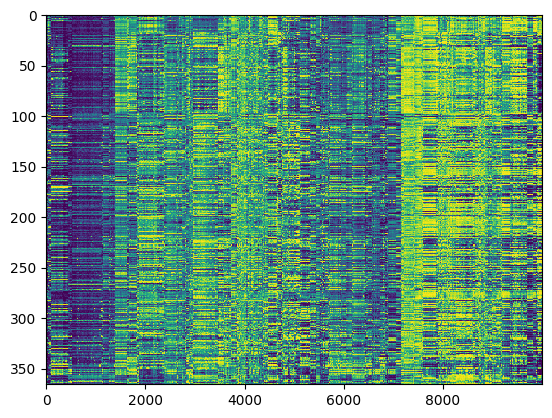

In [34]:
plt.imshow(vectors[Z1['leaves']].T, aspect='auto', interpolation='none')

In [117]:
# vectors_l1_normalized = vectors / vectors.sum(axis=1, keepdims=True)

retrieved_sample_idxs = np.random.choice(len(vectors), 15, replace=False).tolist()

for i in tqdm(range(50)):
    max_features = vectors[retrieved_sample_idxs].max(axis=0)
    scores = np.maximum(vectors, max_features).min(axis=1)
    retrieved_sample_idxs.append(scores.argmax())

  0%|          | 0/50 [00:00<?, ?it/s]

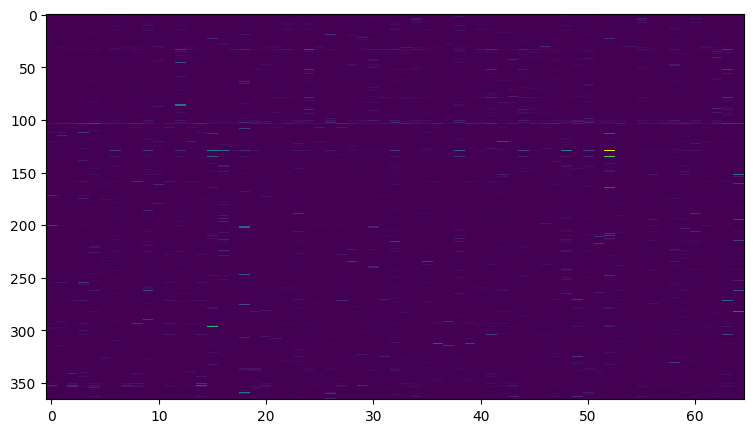

In [118]:
plt.figure(figsize=(9, 5))
plt.imshow(vectors[retrieved_sample_idxs].T, aspect='auto', interpolation='none')

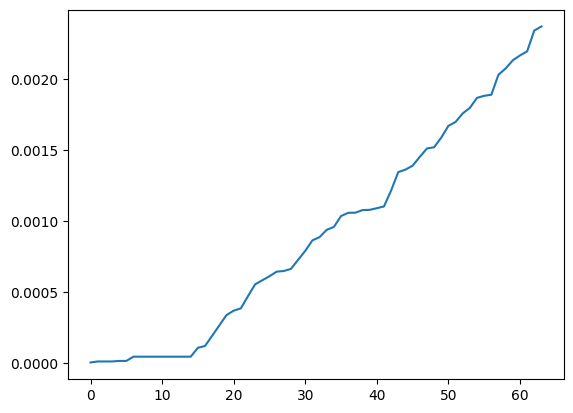

In [119]:
score_dynamics = [
    vectors[retrieved_sample_idxs[:i]].max(axis=0).min()
    for i in range(1, len(retrieved_sample_idxs))
]
plt.plot(score_dynamics)